In [1]:
import TurbPy as tb
from TurbPy.imports import *

In [2]:
# deck = 'KH_Lv1di/'
# deck = 'turb2/'
# deck = 'turb_vth0.01/'
# deck = 'KH_test/'
# deck = 'KH_beta0.1/'
# deck = 'KH_subash/'
# deck = 'KH_new/'
# deck = 'KH_800ppc/'
deck =  'KH_200ppc_200wci/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

twce_out = np.linspace(0, times[-1] * info['dt*wce'], len(en_out['EM']))
twce = np.linspace(0, times[-1] * info['dt*wce'], len(times))

In [3]:
from TurbPy.load_vars import *
from TurbPy.vpic_info import *

def en_calc(dirs, filt = True, save = True):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  
  E_fe = np.zeros(len(times))
  E_the = np.zeros(len(times))
  E_fi = np.zeros(len(times))
  E_thi = np.zeros(len(times))
  E_m = np.zeros(len(times))
  E_e = np.zeros(len(times))

  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']
    if filt == True:
      el = load_hydro_fil(dirs, times[t], 'electron')
      ion = load_hydro_fil(dirs, times[t], 'ion')
      f = load_field_fil(dirs, times[t])
    if filt == False:
      el = load_hydro(dirs, times[t], 'electron')
      ion = load_hydro(dirs,times[t], 'ion')
      f = load_fields(dirs, times[t])

    dbx = f['cbx'] - np.mean(f['cbx'])
    dby = f['cby'] - np.mean(f['cby'])
    dbz = f['cbz'] - np.mean(f['cbz'])
    E_m[t] = (1/2) * np.sum(dbx**2 + dby**2 + dbz**2) * dx * dy * dz
    E_e[t] = (1/2) * np.sum(f['ex']**2 + f['ey']**2 + f['ez']**2) * dx * dy * dz

    particle_mass = int(vpic_info['mi/me'])

    ux=ion['jx']/ion['rho']
    uy=ion['jy']/ion['rho']
    uz=ion['jz']/ion['rho']

    pxx = np.array(ion['txx'] - (ux)*ion['px'])
    pyy = np.array(ion['tyy'] - (uy)*ion['py'])
    pzz = np.array(ion['tzz'] - (uz)*ion['pz'])
    


    E_thi[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fi[t]  = (1/2) * np.sum((ux**2 + uy**2 + uz**2)) * dx * dy * dz
    
    ux=el['jx']/el['rho']
    uy=el['jy']/el['rho']
    uz=el['jz']/el['rho']

    pxx = np.array(el['txx'] - (ux)*el['px'])
    pyy = np.array(el['tyy'] - (uy)*el['py'])
    pzz = np.array(el['tzz'] - (uz)*el['pz'])

    E_the[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
    E_fe[t]  = (1/2) * np.sum(np.abs(el['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

  en['EM'] = E_m
  en['EE'] = E_e
  en['Ethi'] = E_thi
  en['Efi'] = E_fi
  en['Ethe'] = E_the
  en['Efe'] = E_fe
  en['Et'] = E_m + E_e + E_thi + E_fi + E_the + E_fe
  if save == True:
    if filt == False:
      pd.DataFrame(en).to_csv(dirs + 'en_calc.csv', sep = ',')
    if filt == True:
      pd.DataFrame(en).to_csv(dirs + 'en_calc_fil.csv', sep = ',')
  return pd.DataFrame(en)

In [4]:
def read_calc_energies(dirs, filt = True):
  if filt == True:
    fdata = pd.read_csv(dirs + 'en_calc_new.csv')
  else:
    fdata = pd.read_csv(dirs + 'en_calc.csv')
  

  en_dict = {}
  en_dict['EE'] = fdata['EE']
  en_dict['EM'] = fdata['EM']

  en_dict['Ethi'] = fdata['Ethi']
  en_dict['Efi'] = fdata['Efi']
  en_dict['Ei'] = fdata['Efi'] + fdata['Ethi']

  en_dict['Ethe'] = fdata['Ethe']
  en_dict['Efe'] = fdata['Efe']
  en_dict['Ee']  = fdata['Efe'] + fdata['Ethe']
  
  en_dict['Et'] = fdata['Et']
  return pd.DataFrame(en_dict)

In [5]:
t = 290
print(twci[290])
dx = info['dx/de']
dy = info['dy/de']
dz = info['dz/de']
f = load_fields(dirs, times[t])
dbx = f['cbx'] - np.mean(f['cbx'])
dby = f['cby'] - np.mean(f['cby'])
dbz = f['cbz'] - np.mean(f['cbz'])
E_m = (1/2) * np.sum(dbx**2 + dby**2 + dbz**2) * dx * dy * dz/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
print(E_m)

40.05097200000001
0.000397963784635067


In [6]:
# en = read_calc_energies(dirs, filt = False)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
en = en_calc(dirs, filt = False)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

print(en)

                EM        EE      Ethi       Efi      Ethe       Efe        Et
0     1.707227e-12  0.000065  0.018721  0.000262  0.018154  0.000286  0.037489
1     1.640748e-06  0.000073  0.018725  0.000262  0.018145  0.000314  0.037521
2     3.134654e-06  0.000075  0.018734  0.000262  0.018144  0.000289  0.037508
3     4.801100e-06  0.000075  0.018748  0.000262  0.018142  0.000308  0.037540
4     6.645371e-06  0.000079  0.018766  0.000262  0.018141  0.000297  0.037551
...            ...       ...       ...       ...       ...       ...       ...
1120  1.371420e-03  0.000124  0.020606  0.000180  0.023225  0.000393  0.045901
1121  1.373134e-03  0.000124  0.020608  0.000180  0.023231  0.000395  0.045911
1122  1.374758e-03  0.000124  0.020610  0.000180  0.023236  0.000395  0.045920
1123  1.376640e-03  0.000124  0.020612  0.000180  0.023242  0.000396  0.045930
1124  1.378408e-03  0.000124  0.020613  0.000180  0.023247  0.000397  0.045939

[1125 rows x 7 columns]


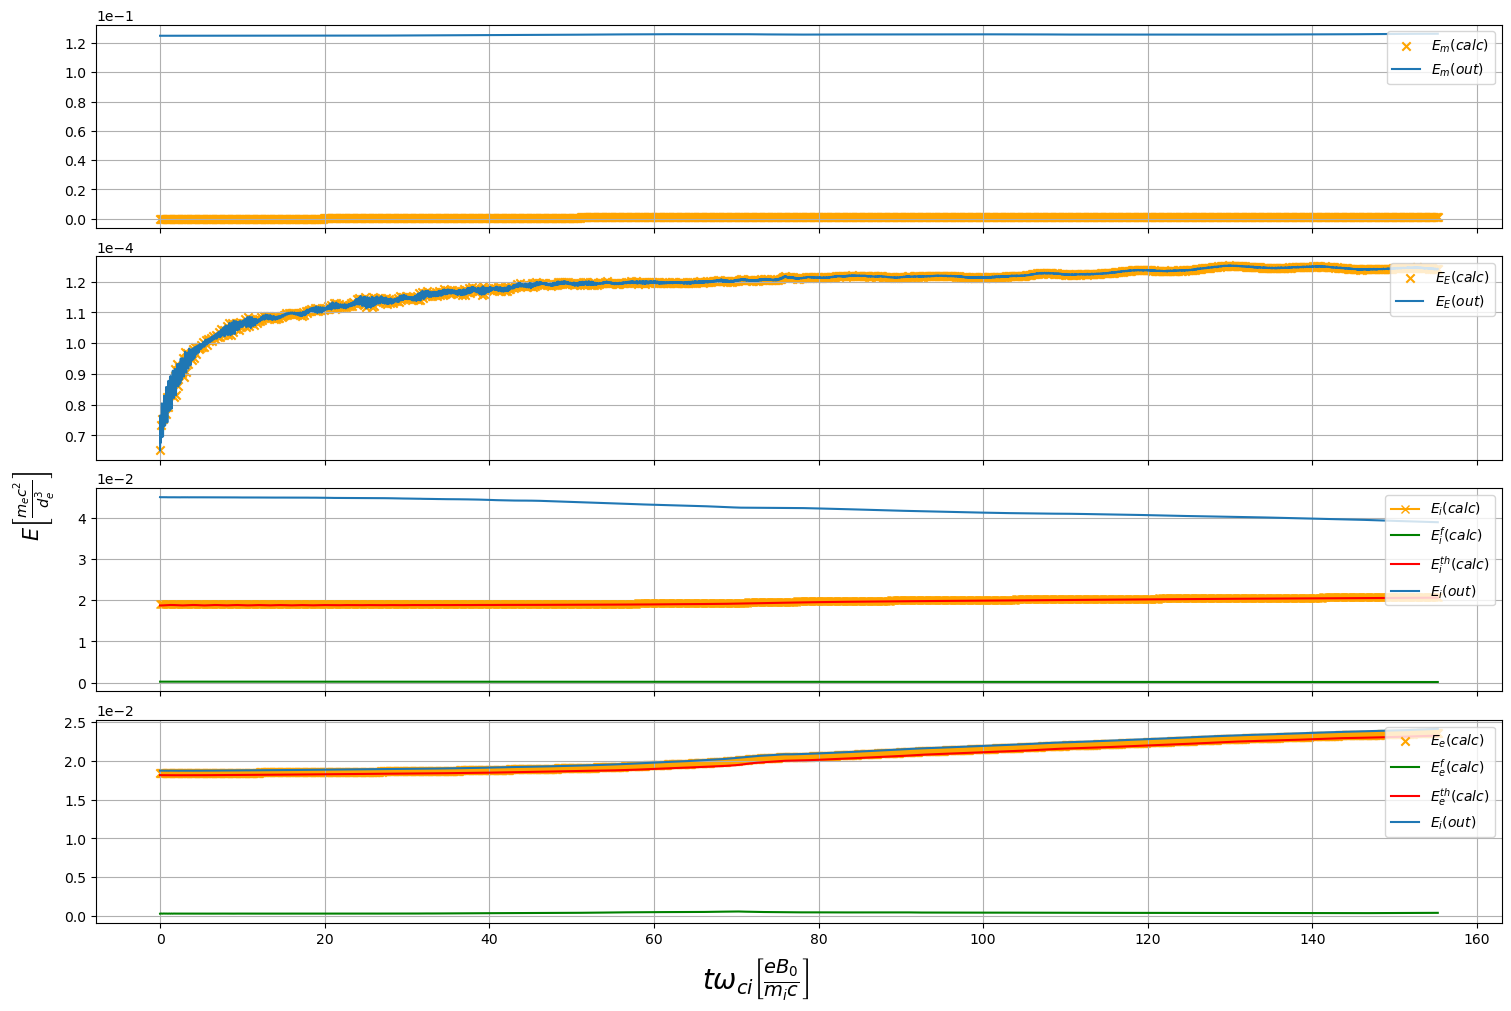

In [7]:
fig, axs = plt.subplots(4,1, figsize=(15, 10), sharex = True, layout='constrained')
axs[0].scatter(twci, en['EM'], color = 'orange', marker = 'x', label = r'$E_m (calc)$')
axs[0].plot(twci_out, en_out['EM'] , label = r'$E_m (out)$')

axs[1].scatter(twci, en['EE'], color = 'orange', marker = 'x', label = r'$E_E (calc)$')
axs[1].plot(twci_out, en_out['EE'], label = r'$E_E (out)$')

axs[2].plot(twci, en['Ethi'] + en['Efi'], color = 'orange', marker = 'x' , label = r'$E_i (calc)$')
axs[2].plot(twci, en['Efi'], color = 'green' , label = r'$E^{f}_i (calc)$')
axs[2].plot(twci, en['Ethi'], color = 'red' , label = r'$E^{th}_i (calc)$')
axs[2].plot(twci_out, en_out['Ei'],label = r'$E_i (out)$')

axs[3].scatter(twci, (en['Ethe'] + en['Efe']), color = 'orange', marker = 'x', label = r'$E_e (calc)$')
axs[3].plot(twci, en['Efe'], color = 'green', label = r'$E^{f}_e (calc)$')
axs[3].plot(twci, en['Ethe'], color = 'red' , label = r'$E^{th}_e (calc)$')
axs[3].plot(twci_out, en_out['Ee'],label = r'$E_i (out)$')


axs[0].legend(loc = 'upper right')
axs[1].legend(loc = 'upper right')
axs[2].legend(loc = 'upper right')
axs[3].legend(loc = 'upper right')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()

axs[0].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[1].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[2].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs[3].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 20)

plt.savefig(figs + 'en_comp_calc.jpg', dpi = 400)

Text(0.5, 0.01, '$ t \\omega_{ci}$')

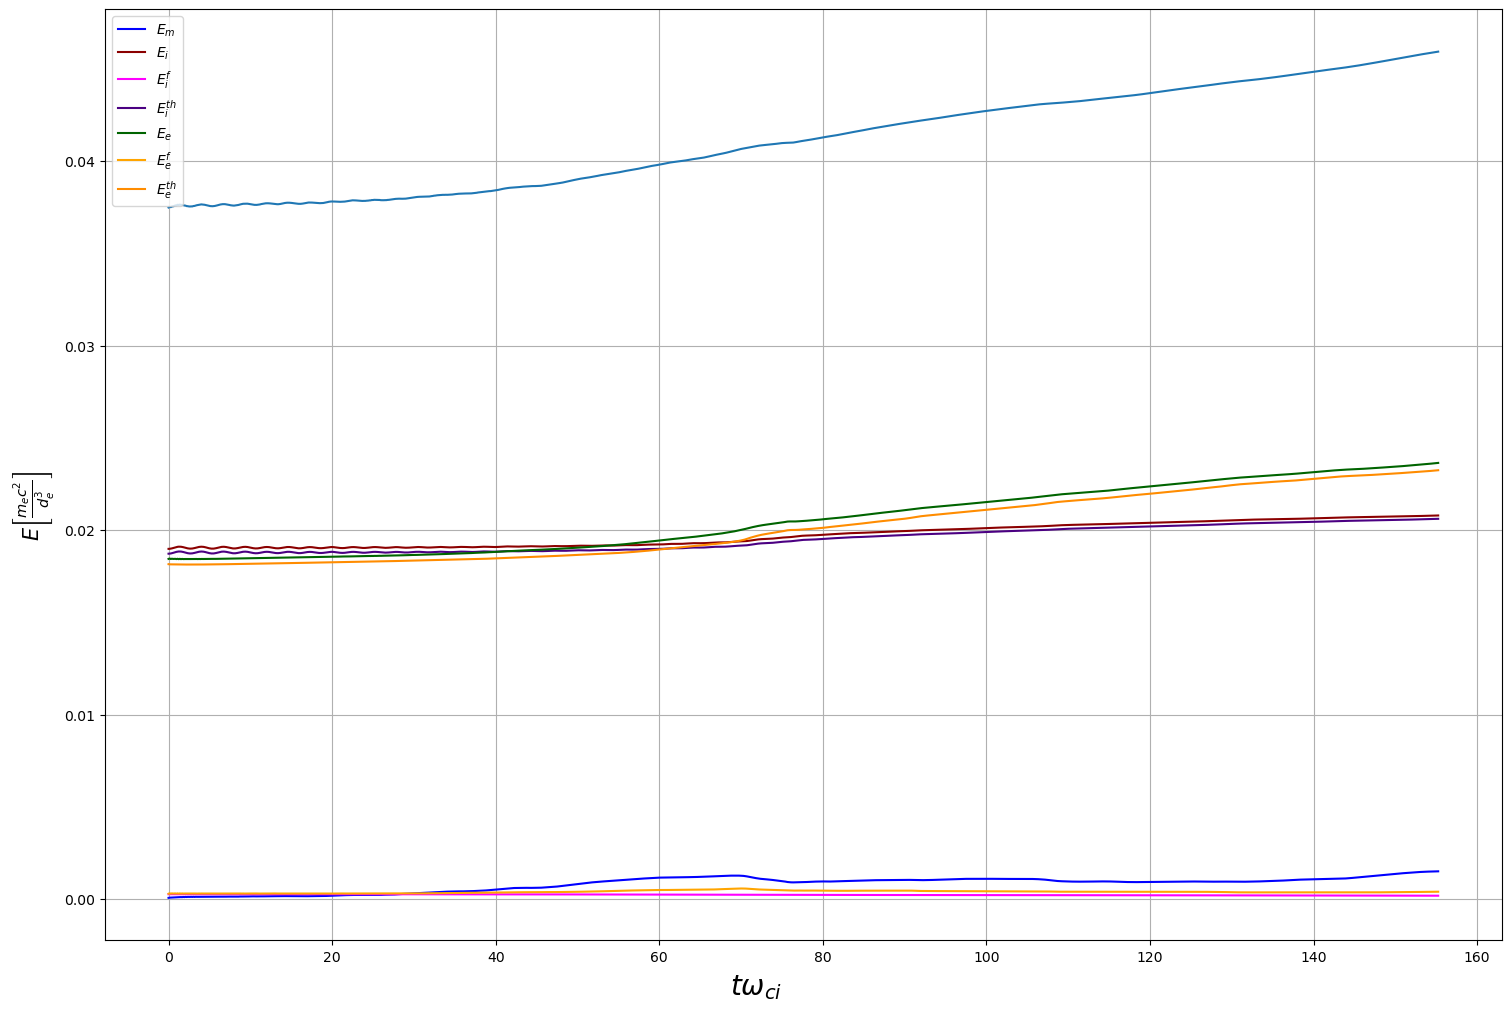

In [8]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
axs.plot(twci, en['EM'] + en['EE'], color = 'blue', label = r'$E_m$')
# axs.plot(twci_out, en_out['EM'] + en_out['EE'] , color = 'aqua', label = r'$E_m (out)$')

axs.plot(twci, en['Ethi'] + en['Efi'], color = 'darkred' , label = r'$E_i$')
axs.plot(twci, en['Efi'], color = 'fuchsia' , label = r'$E^{f}_i$')
axs.plot(twci, en['Ethi'], color = 'indigo' , label = r'$E^{th}_i$')
# axs.plot(twci_out, en_out['Ei'], color = 'mistyrose',label = r'$E_i (out)$')

axs.plot(twci, (en['Ethe'] + en['Efe']), color = 'darkgreen', label = r'$E_e$')
axs.plot(twci, en['Efe'], color = 'orange', label = r'$E^{f}_e $')
axs.plot(twci, en['Ethe'], color = 'darkorange' , label = r'$E^{th}_e$')
axs.plot(twci, en['Et'])
# axs.plot(twci_out, en_out['Ee'], color = 'lime', label = r'$E_e (out)$')

# axs.set_yscale('log')
axs.legend()

axs.grid(which = 'both')


# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))


fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
fig.supxlabel(r'$ t \omega_{ci}$', size = 20)

# plt.savefig(figs + 'energy.jpg', dpi = 400)

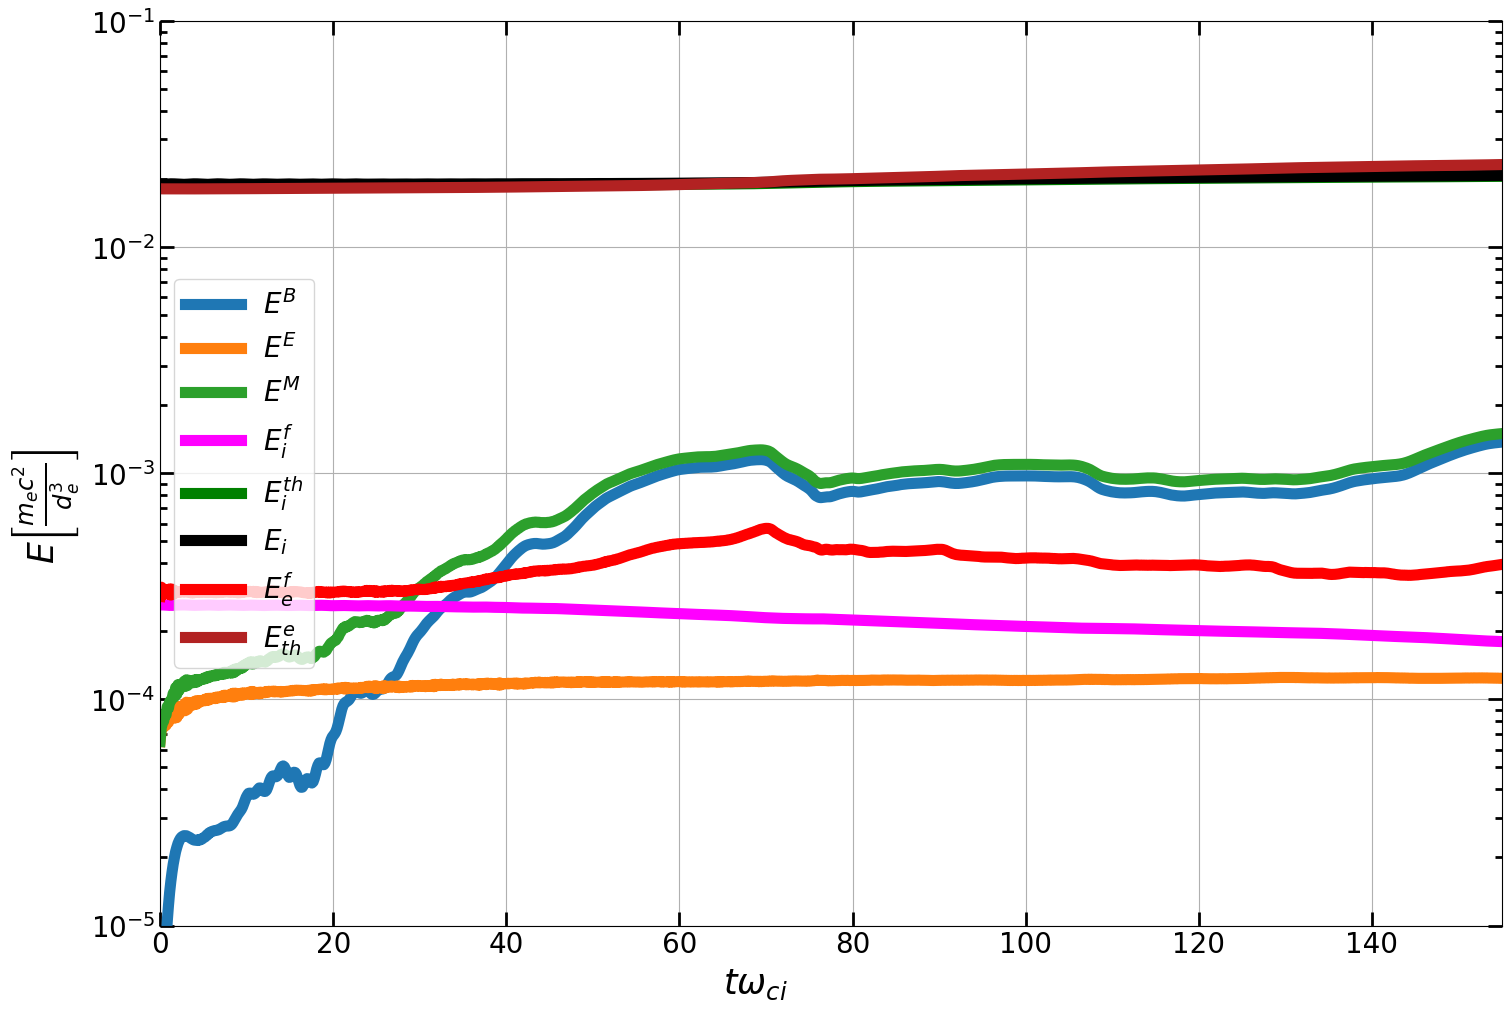

In [16]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
import matplotlib
matplotlib.rc('font', size=10)

lw = 8
axs.plot(twci, (en['EM']),linewidth = lw, label = r'$E^B$')
axs.plot(twci, (en['EE']),linewidth = lw , label = r'$E^E$')
axs.plot(twci, (en['EM'] + en['EE']),linewidth = lw, label = r'$E^M$')

sp = 'ion'
axs.plot(twci, en['Efi'],  color = 'fuchsia', linewidth = lw,label = r'$E^{f}_i$')
axs.plot(twci, en['Ethi'],color = 'green', linewidth = lw,label = r'$E^{th}_'f'{sp[0]}''$')
axs.plot(twci, (en['Ethi'] + en['Efi']),color = 'black', linewidth = lw,label = r'$E_'f'{sp[0]}''$')

sp = 'electron'
axs.plot(twci, en['Efe'],  color = 'red', linewidth = lw,label = r'$E^{f}_e$')
axs.plot(twci, en['Ethe'], color = 'firebrick', linewidth = lw,label = r'$E_{th}^'f'{sp[0]}''$')
# axs.plot(twci, en['Ethe'] + en['Efe'],color = 'gray', linewidth = lw,label = r'$E_'f'{sp[0]}''$')
# axs.plot(twci[n:], dEt[n:], color = 'black',linewidth = 3, label = r'$\delta E_T$')

# axs.plot(twci[n:], JE_int - JE_int[n] , linewidth = 3, color = 'blue', label = r'$\int_{'f'{time_twci}'r'}^t - \langle J \cdot E \rangle'' dt$')
# sp = 'ion'
# axs.plot(twci[n:], psi_JiE,  color = 'chocolate', linewidth = 3,label = r'$\int_{'f'{time_twci}'r'}^t PS_'f'{sp[0]}'r'+ \langle J_'f'{sp[0]}'r'\cdot E \rangle dt$')
# axs.plot(twci[n:], psi_int, color = 'green', linewidth = 3,label = r'$\int_{'f'{time_twci}'r'}^t PS_'f'{sp[0]}'' dt$')
# sp = 'electron'
# axs.plot(twci[n:], pse_JeE,  color = 'indigo', linewidth = 3,label = r'$\int_{'f'{time_twci}'r'}^t PS_'f'{sp[0]}'r'+ \langle J_'f'{sp[0]}'r'\cdot E \rangle dt$')
# axs.plot(twci[n:], pse_int, color = 'salmon',linewidth = 3, label = r'$\int_{'f'{time_twci}'r'}^t PS_'f'{sp[0]}'' dt$')

axs.set_xlim(0, 155)
# axs.set_ylim(-4e-3, 2e-3)


# reordering the labels 
# handles, labels = plt.gca().get_legend_handles_labels() 
  
# specify order 
# order = [0,1,2,3,4,5,6,7,8,9]

# axs.legend([handles[i] for i in order], [labels[i] for i in order], loc = 'lower left', fontsize = 20, ncols = 2, frameon = False)

axs.set_yscale('log')
# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
plt.rc('font', size = 20)
axs.legend(loc = 'best')
# axs.xaxis.set_minor_locator(AutoMinorLocator())
# axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
axs.tick_params(which='major', length=10, top = True, right =True)
axs.tick_params(which='minor', length=5 , top = True, right =True)
axs.set_ylim(10**(-5), 10**(-1))
axs.grid()
fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 25)
fig.supxlabel(r'$ t \omega_{ci}$', size = 25)

plt.savefig(figs + 'E.png', dpi = 400)

In [10]:
print(en['EM'][290])
print(en['Efi'][290])

0.000397963784635067
0.0002550951950252056


In [11]:
print((np.array(en_out['Et'])[-1] - en_out['Et'][0])/en_out['Et'][0] * 100)

0.39886201945039806


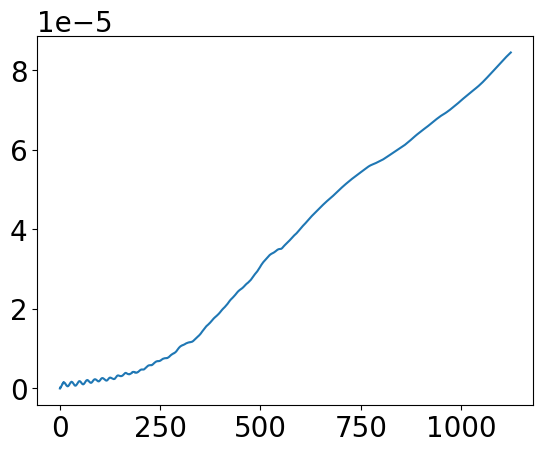

In [12]:
plt.plot((np.array(en['Et']) - en['Et'][0])/100)